# LDA with TF-IDF

In [3]:
! pip install gensim
! pip install pyLDAvis
!pip install numpy==1.22
%pip install contractions
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3, but you have numpy 1.22.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simpl

In [24]:
import numpy as np
import pandas as pd
import scipy as scs
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
import datetime as dt
import re
import string
import contractions

import gensim
from gensim import models
from gensim.utils import simple_preprocess
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')

import gensim.corpora as corpora
import pprint

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

pd.set_option("display.max_columns", 50, "display.max_rows", 100)
pp = pprint.PrettyPrinter(indent=4)
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import auth
auth.authenticate_user()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Import

In [7]:
sql = ('''SELECT *
                FROM pg-duke-student-capstone-v1.final_merged.clean_nps
                ''')
project_id = 'pg-duke-student-capstone-v1'
proj_num = '545682952716'
client = bigquery.Client(project=project_id)
df_nps = pd.read_gbq(sql, project_id=project_id, dialect="standard")
df_nps.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,int64_field_0,application_id,product_type,respondent_id,survey_key,created_at,score,zendesk_ticket_id,medium,verbatim,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None
2,1389,841048.0,homeandauto,850431113,o9BFKWnnOducRd4AjQcETyjbHbTj0xQb,2021-04-02 16:57:16+00:00,9,None,None,Working with you was fast and easy and I like ...,2f359d6cde594f309b0989e96ce2454f,2f359d6cde594f309b0989e96ce2454f,male,WI,NaN,56.0,Direct,Desktop,NaN,0.0,<NA>,single,NaN,None
3,1398,1454888.0,homeandauto,1047155544,BHUlqVZW1c5am64nlz3rXnnJop68iqXS,2022-01-06 13:03:58+00:00,10,None,None,My agent was very informed and help make the p...,052feaa8c2a14c94953481e4c0567dd3,052feaa8c2a14c94953481e4c0567dd3,male,CA,NaN,28.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None
4,1419,1544133.0,homeandauto,1075912288,qSi8fsNFAjS3atrE54cmsd52Mec8gsmP,2022-02-17 11:47:16+00:00,10,None,None,I got my insurance for both vehicles cut in ha...,653fc046465e40dc8b3b0f73a17bdcfd,653fc046465e40dc8b3b0f73a17bdcfd,male,LA,NaN,35.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None


# Data Preprocessing

Add date, month, year variables and variables for categorising NPS categories

In [25]:
df_nps['date'] = pd.to_datetime(df_nps['created_at'])
# df_nps['day'] = df_nps['date'].dt.day
df_nps['month'] = df_nps['date'].dt.month
df_nps['year'] = df_nps['date'].dt.year
# df_nps["month-year"] = df_nps.month.astype(str) + "-" + df_nps.year.astype(str)
df_nps["score_categorized"] = pd.cut(df_nps.score, bins=[-np.inf, 6, 8, 10],
                  labels=["detractor", "passive", "promoter"])

Subset data into promoters, passive, detractors

In [26]:
prom = df_nps[df_nps['score_categorized'] == 'promoter']
passive = df_nps[df_nps['score_categorized'] == 'passive']
det = df_nps[df_nps['score_categorized'] == 'detractor']

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

Tokenisation, Normalization, remove stopwords, and remove punctuations

In [28]:
stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 'use', 'policygenius', 'policy', 'genius','insurance', "pg", 'none', 'na', "able", "already", "also",
                   "was", 'got', "were", "thus", "although", "always", "bc", "because", "definitely", "could", "couldnt", 'would', "wouldnt"])

def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    #text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()])) # isn't --> is not

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in stop_words if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    from nltk.stem import WordNetLemmatizer
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()])) # terms --> term

    # stemming
    # from nltk.stem import PorterStemmer
    # text_col = text_col.apply(lambda x: ' '.join([PorterStemmer().stem(w) for w in x.split()])) # asking --> ask

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
      #yield(lemmatize_text(sentence))
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
          # simple_preprocess did: lowercases, tokenization, de-accent

        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [30]:
data2 = preprocess(df_nps["verbatim"])
prom_data = preprocess(prom["verbatim"])
pass_data = preprocess(passive["verbatim"])
det_data = preprocess(det["verbatim"])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [31]:
from gensim import corpora, models


In [32]:
prom_words = list(sent_to_words(prom_data))
prom_words = remove_stopwords(prom_words)
print(prom_words[1][:10])

['working', 'fast', 'easy', 'like', 'result']


In [33]:
pass_words = list(sent_to_words(pass_data))
pass_words = remove_stopwords(pass_words)
print(pass_words[1][:10])

['talking', 'another', 'guy', 'ghdn', 'message', 'realize', 'company', 'mail', 'poljcy', 'grnius']


In [34]:
det_words = list(sent_to_words(det_data))
det_words = remove_stopwords(det_words)
print(det_words[1][:10])

['ask', 'question', 'secure', 'web', 'site', 'difficult', 'access']


In [35]:
data_words = list(sent_to_words(data2))
data_words = remove_stopwords(data_words)
print(data_words[1][:10])

['experience', 'great', 'easy']


Turn unigram to bigrams

In [36]:
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=2) # higher threshold will result in fewer phrases
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = [bigram_mod[sent] for sent in data_words]


prom_bigram = gensim.models.Phrases(prom_words, min_count=1, threshold=2) # higher threshold will result in fewer phrases
prom_bigram_mod = gensim.models.phrases.Phraser(prom_bigram)
prom_words_bigrams = [prom_bigram_mod[sent] for sent in prom_words]

pass_bigram = gensim.models.Phrases(pass_words, min_count=1, threshold=2) # higher threshold will result in fewer phrases
pass_bigram_mod = gensim.models.phrases.Phraser(pass_bigram)
pass_words_bigrams = [pass_bigram_mod[sent] for sent in pass_words]

det_bigram = gensim.models.Phrases(det_words, min_count=1, threshold=2) # higher threshold will result in fewer phrases
det_bigram_mod = gensim.models.phrases.Phraser(det_bigram)
det_words_bigrams = [det_bigram_mod[sent] for sent in det_words]

In [37]:
prom_words_bigrams[:2]
pass_words_bigrams[:2]
det_words_bigrams[:2]


[['web_site',
  'faulty',
  'update',
  'progress',
  'correctly',
  'felt',
  'process',
  'transparent',
  'good_communication',
  'agent',
  'approval',
  'completed'],
 ['ask_question', 'secure', 'web_site', 'difficult', 'access']]

Converting words to trigrams for each segments

In [38]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=3)
trigram_mod = gensim.models.phrases.Phraser(trigram)
data_words_trigrams = [trigram_mod[sent] for sent in data_words_bigrams]

prom_trigram = gensim.models.Phrases(prom_bigram[prom_words], threshold=3)
prom_trigram_mod = gensim.models.phrases.Phraser(prom_trigram)
prom_words_trigrams = [prom_trigram_mod[sent] for sent in prom_words_bigrams]

pass_trigram = gensim.models.Phrases(pass_bigram[pass_words], threshold=3)
pass_trigram_mod = gensim.models.phrases.Phraser(pass_trigram)
pass_words_trigrams = [pass_trigram_mod[sent] for sent in pass_words_bigrams]

det_trigram = gensim.models.Phrases(det_bigram[det_words], threshold=3)
det_trigram_mod = gensim.models.phrases.Phraser(det_trigram)
det_words_trigrams = [det_trigram_mod[sent] for sent in det_words_bigrams]

In [39]:
det_words_trigrams[:3]

[['web_site',
  'faulty',
  'update',
  'progress',
  'correctly',
  'felt',
  'process',
  'transparent',
  'good_communication',
  'agent',
  'approval',
  'completed'],
 ['ask_question', 'secure', 'web_site', 'difficult', 'access'],
 ['first_time',
  'heard',
  'need',
  'little',
  'time',
  'recommend',
  'far',
  'good_experience']]

Create dictionary and corpus for LDA modelling

In [40]:
dictionary = corpora.Dictionary(data_words_trigrams)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2500)
texts = data_words_trigrams
corpus = [dictionary.doc2bow(text) for text in texts]

prom_dictionary = corpora.Dictionary(prom_words_trigrams)
prom_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2500)
prom_texts = prom_words_trigrams
prom_corpus = [prom_dictionary.doc2bow(text) for text in prom_texts]

pass_dictionary = corpora.Dictionary(pass_words_trigrams)
pass_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2500)
pass_texts = pass_words_trigrams
pass_corpus = [pass_dictionary.doc2bow(text) for text in pass_texts]

det_dictionary = corpora.Dictionary(det_words_trigrams)
det_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2500)
det_texts = det_words_trigrams
det_corpus = [det_dictionary.doc2bow(text) for text in det_texts]

Create TFIDF models for each segment

In [42]:
tfidf = models.TfidfModel(corpus, normalize=True)

prom_tfidf = models.TfidfModel(prom_corpus, normalize=True)
pass_tfidf = models.TfidfModel(pass_corpus, normalize=True)
det_tfidf = models.TfidfModel(det_corpus, normalize=True)

In [43]:
corpus_tfidf = tfidf[corpus]
prom_corpus_tfidf = prom_tfidf[prom_corpus]
pass_corpus_tfidf = pass_tfidf[pass_corpus]
det_corpus_tfidf = det_tfidf[det_corpus]

# LDA Modelling

Create LDA models with 5 and 8 topics

In [44]:
with np.errstate(invalid='ignore'):
  lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics = 5, id2word=dictionary, chunksize = 100,
                                             
                                             iterations= 25, passes=2, workers=3)

In [45]:
lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics = 8, id2word=dictionary, chunksize = 100,
                                             
                                             iterations= 25, passes=2, workers=3)

Print out the top key words for each topic for LDA model with 8 topics

In [46]:
for idx, topic in lda_model_tfidf.print_topics(-1):
  print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.045*"easy_work" + 0.032*"ease" + 0.030*"helpful" + 0.026*"good" + 0.017*"fast" + 0.015*"professional" + 0.015*"smooth_process" + 0.015*"super_easy" + 0.014*"process_simple" + 0.013*"nice"
Topic: 1 Word: 0.083*"easy" + 0.026*"great" + 0.025*"friendly" + 0.022*"excellent_service" + 0.021*"great_rate" + 0.016*"convenient" + 0.014*"helpful" + 0.014*"experience" + 0.012*"easy_convenient" + 0.012*"thank"
Topic: 2 Word: 0.066*"great_service" + 0.022*"fast_easy" + 0.018*"process_easy" + 0.014*"easy_fast" + 0.012*"communication" + 0.011*"rep" + 0.009*"process" + 0.009*"straightforward" + 0.007*"help" + 0.007*"convenience"
Topic: 3 Word: 0.026*"service" + 0.014*"price" + 0.014*"responsive" + 0.013*"great" + 0.013*"excellent" + 0.012*"quick_response" + 0.012*"support" + 0.012*"good_experience" + 0.012*"prompt" + 0.012*"work"
Topic: 4 Word: 0.025*"good_service" + 0.022*"efficient" + 0.018*"good_communication" + 0.017*"good_customer_service" + 0.013*"easy" + 0.013*"best" + 0.011*"s

### LDA topic-word distribution
Create a bar plot visualisation to show topic-word distribution for LDA model wih 8 topics

In [47]:
words = []
numbers = []
for idx, topic in lda_model_tfidf.print_topics(-1):
  print('Topic: {} Word: {}'.format(idx, topic))
  num_word = topic.split(" + ")
  print(num_word[0])
  number_list = []
  word_list = []
  for each in num_word:
    per = each.split("*")
    number = float (per[0])
    word = per[1][1:-1]
    number_list.append(number)
    word_list.append(word)
  
  words.append(word_list)
  numbers.append(number_list)


Topic: 0 Word: 0.045*"easy_work" + 0.032*"ease" + 0.030*"helpful" + 0.026*"good" + 0.017*"fast" + 0.015*"professional" + 0.015*"smooth_process" + 0.015*"super_easy" + 0.014*"process_simple" + 0.013*"nice"
0.045*"easy_work"
Topic: 1 Word: 0.083*"easy" + 0.026*"great" + 0.025*"friendly" + 0.022*"excellent_service" + 0.021*"great_rate" + 0.016*"convenient" + 0.014*"helpful" + 0.014*"experience" + 0.012*"easy_convenient" + 0.012*"thank"
0.083*"easy"
Topic: 2 Word: 0.066*"great_service" + 0.022*"fast_easy" + 0.018*"process_easy" + 0.014*"easy_fast" + 0.012*"communication" + 0.011*"rep" + 0.009*"process" + 0.009*"straightforward" + 0.007*"help" + 0.007*"convenience"
0.066*"great_service"
Topic: 3 Word: 0.026*"service" + 0.014*"price" + 0.014*"responsive" + 0.013*"great" + 0.013*"excellent" + 0.012*"quick_response" + 0.012*"support" + 0.012*"good_experience" + 0.012*"prompt" + 0.012*"work"
0.026*"service"
Topic: 4 Word: 0.025*"good_service" + 0.022*"efficient" + 0.018*"good_communication" + 0

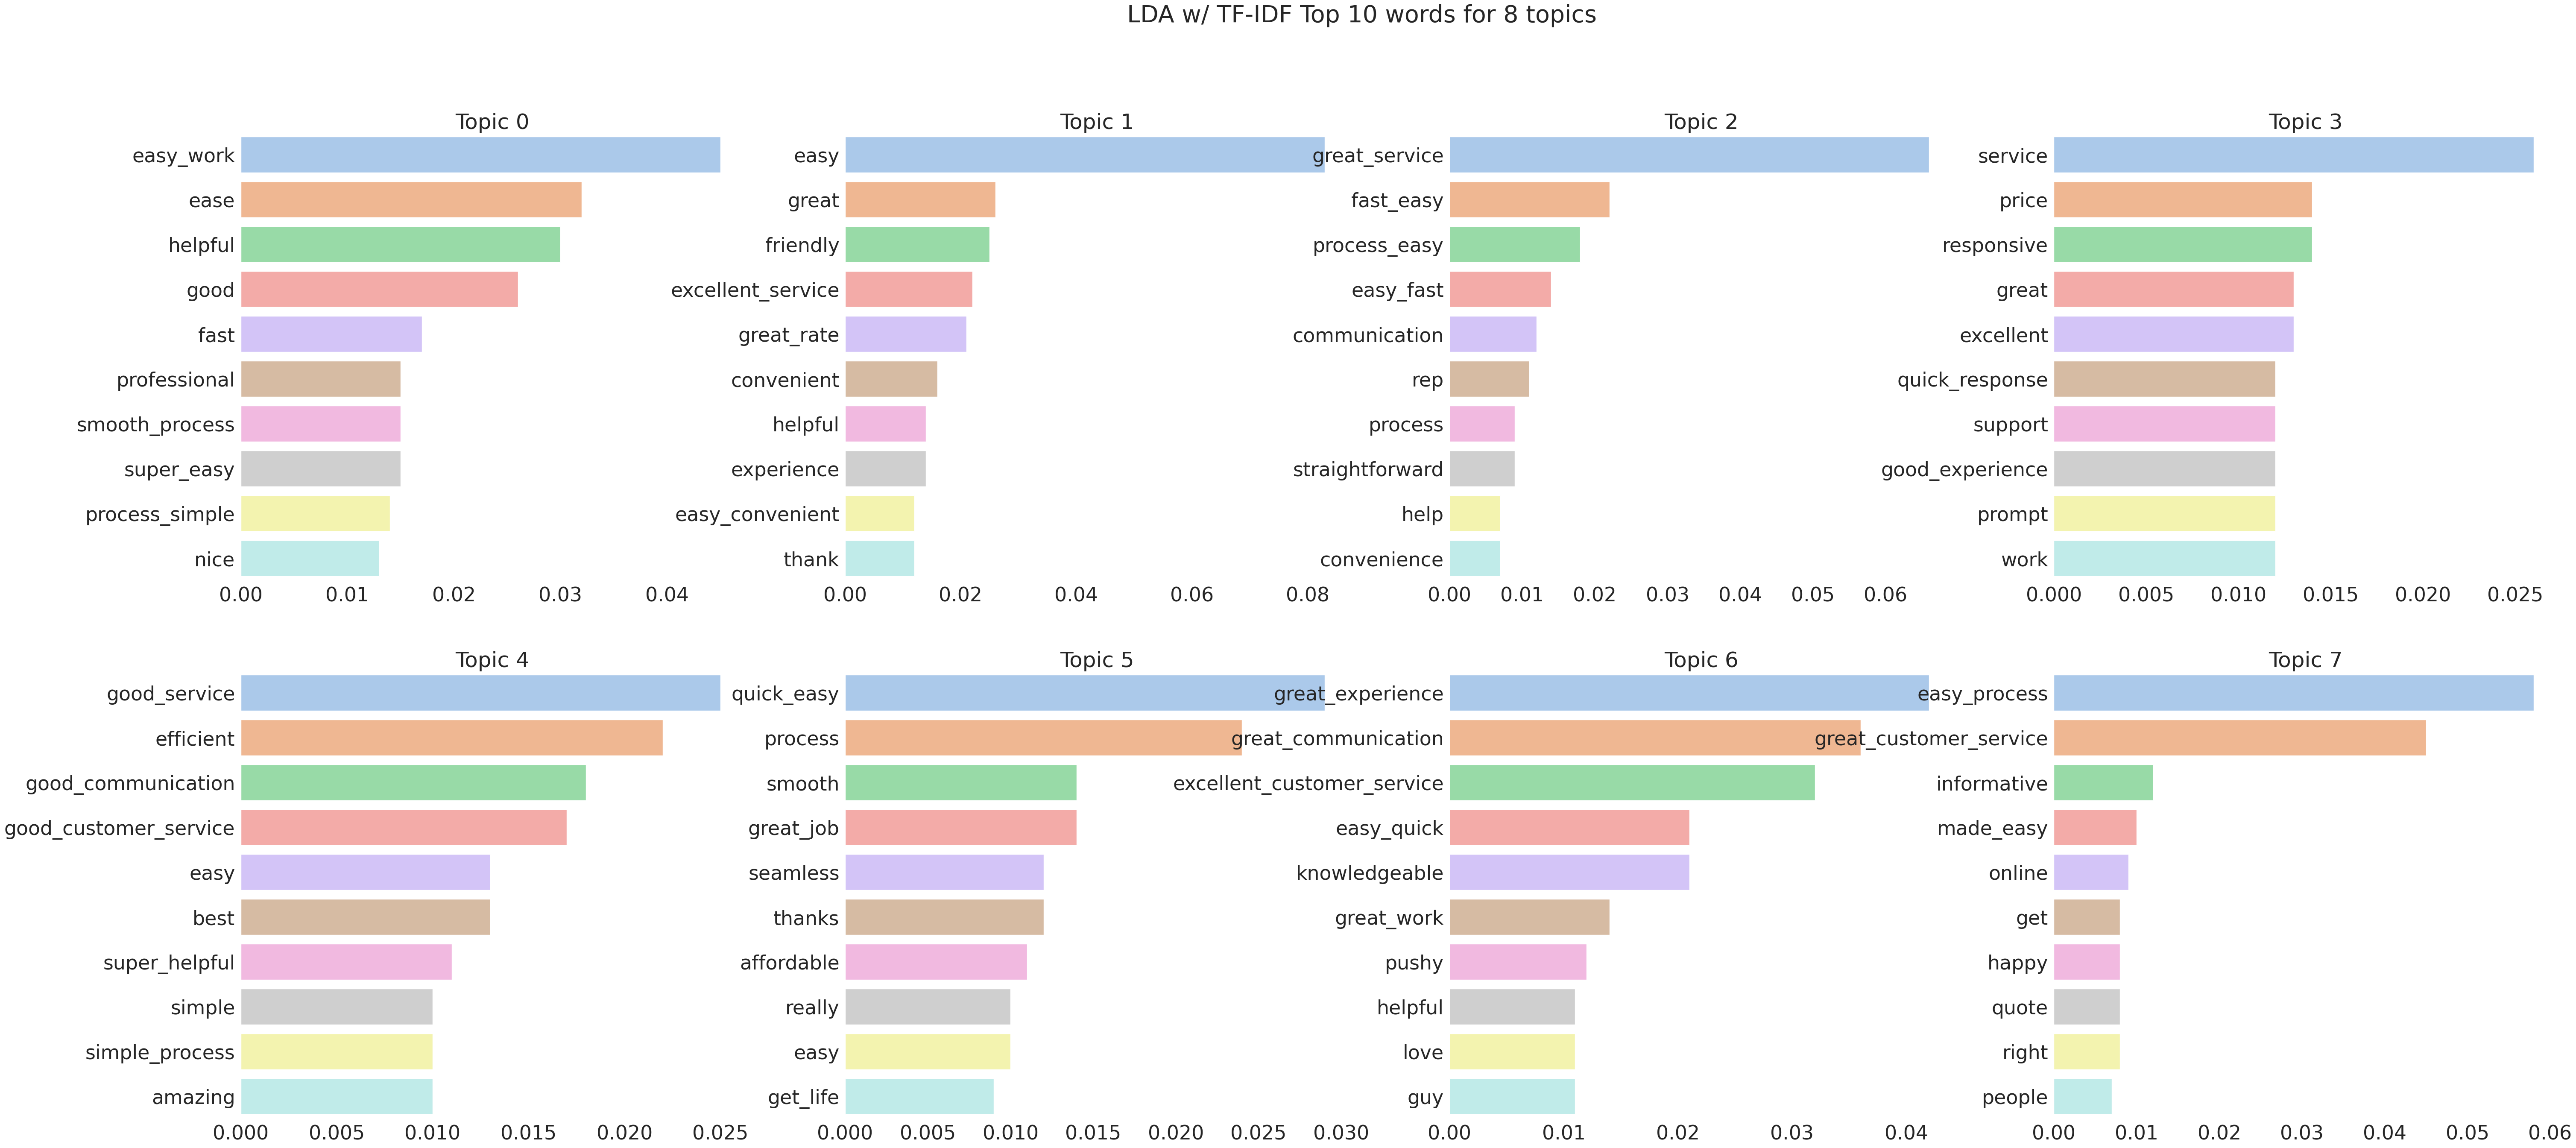

In [50]:
plt.figure(figsize=(70, 30))
nrow = 2
ncol = 4
i = 1
plt.suptitle("LDA w/ TF-IDF Top 10 words for 8 topics", fontsize=40)

for j in range(len(numbers)):
  sns.set_style(style='white')
  # sns.set(font_scale=3)
  plt.subplot(nrow, ncol, i)
  sns.set_style(style='white')
  sns.barplot(x=numbers[j], y=words[j], orient='h', palette='pastel')
  i+=1
  sns.despine(bottom=True, left=True)

  plt.title("Topic " + str(j))

# plt.title("LDA Top 10 words for 8 topics")
plt.show()


In [51]:
for idx, topic in lda_model_tfidf.print_topics(-1):
  print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.045*"easy_work" + 0.032*"ease" + 0.030*"helpful" + 0.026*"good" + 0.017*"fast" + 0.015*"professional" + 0.015*"smooth_process" + 0.015*"super_easy" + 0.014*"process_simple" + 0.013*"nice"
Topic: 1 Word: 0.083*"easy" + 0.026*"great" + 0.025*"friendly" + 0.022*"excellent_service" + 0.021*"great_rate" + 0.016*"convenient" + 0.014*"helpful" + 0.014*"experience" + 0.012*"easy_convenient" + 0.012*"thank"
Topic: 2 Word: 0.066*"great_service" + 0.022*"fast_easy" + 0.018*"process_easy" + 0.014*"easy_fast" + 0.012*"communication" + 0.011*"rep" + 0.009*"process" + 0.009*"straightforward" + 0.007*"help" + 0.007*"convenience"
Topic: 3 Word: 0.026*"service" + 0.014*"price" + 0.014*"responsive" + 0.013*"great" + 0.013*"excellent" + 0.012*"quick_response" + 0.012*"support" + 0.012*"good_experience" + 0.012*"prompt" + 0.012*"work"
Topic: 4 Word: 0.025*"good_service" + 0.022*"efficient" + 0.018*"good_communication" + 0.017*"good_customer_service" + 0.013*"easy" + 0.013*"best" + 0.011*"s

### Iterating the number of tpoics in LDA

In [53]:
def topic_model(num_topics, npasses=10, prob = 1e-8, model=lda_model_tfidf, corpus=corpus, dictionary = dictionary):
  print("[Running LDA with number of topics : {}]".format(num_topics))
  # lda_model = models.LdaModel(corpus=corpus_tfidf, id2word = dictionary, num_topics=num_topics, passes = npasses, alpha='asymmetric', minimum_probability=prob, random_state = 1)
  
  print("Topic distribution:\n")
  pp.pprint(model.print_topics())
  print("\n")
  
  # Generating LDA visualization
  pyLDAvis.enable_notebook()

  LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))

  if 1 == 1:
      LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
      with open(LDAvis_data_filepath, 'wb') as f:
          pickle.dump(LDAvis_prepared, f)# load the pre-prepared pyLDAvis data from disk

  with open(LDAvis_data_filepath, 'rb') as f:
      LDAvis_prepared = pickle.load(f)
      pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
      display(LDAvis_prepared)

Example showing LDA model with 8 topics and its intertopic distance map

In [54]:
topic_model(8)

[Running LDA with number of topics : 8]
Topic distribution:

[   (   0,
        '0.045*"easy_work" + 0.032*"ease" + 0.030*"helpful" + 0.026*"good" + '
        '0.017*"fast" + 0.015*"professional" + 0.015*"smooth_process" + '
        '0.015*"super_easy" + 0.014*"process_simple" + 0.013*"nice"'),
    (   1,
        '0.083*"easy" + 0.026*"great" + 0.025*"friendly" + '
        '0.022*"excellent_service" + 0.021*"great_rate" + 0.016*"convenient" + '
        '0.014*"helpful" + 0.014*"experience" + 0.012*"easy_convenient" + '
        '0.012*"thank"'),
    (   2,
        '0.066*"great_service" + 0.022*"fast_easy" + 0.018*"process_easy" + '
        '0.014*"easy_fast" + 0.012*"communication" + 0.011*"rep" + '
        '0.009*"process" + 0.009*"straightforward" + 0.007*"help" + '
        '0.007*"convenience"'),
    (   3,
        '0.026*"service" + 0.014*"price" + 0.014*"responsive" + 0.013*"great" '
        '+ 0.013*"excellent" + 0.012*"quick_response" + 0.012*"support" + '
        '0.012*"good_e

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.099550  0.042018       1        1  15.916294
3      0.058988  0.047126       2        1  15.116118
2      0.060181  0.015179       3        1  14.286200
4      0.099106 -0.175703       4        1  13.013240
1     -0.083009  0.050793       5        1  12.380023
5      0.084767 -0.136954       6        1  10.948941
0     -0.010794  0.248356       7        1  10.650468
6     -0.308791 -0.090816       8        1   7.688716, topic_info=                       Term         Freq        Total Category  logprob  \
263           great_service   663.000000   663.000000  Default  30.0000   
38             easy_process   701.000000   701.000000  Default  29.0000   
160  great_customer_service   494.000000   494.000000  Default  28.0000   
2                      easy  1271.000000  1271.000000  Default  27.0000   
431               easy_work   336.000000   336.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
288                   staff    47.395110   165.967570   Topic8  -4.7210   
330        highly_recommend    38.255550    64.399965   Topic8  -4.9352   
20                  helpful    59.193995   675.786551   Topic8  -4.4987   
2                      easy    55.646926  1271.081693   Topic8  -4.5605   
15                  process    49.568184   721.152218   Topic8  -4.6761   

     loglift  
263  30.0000  
38   29.0000  
160  28.0000  
2    27.0000  
431  26.0000  
..       ...  
288   1.3121  
330   2.0446  
20    0.1304  
2    -0.5632  
15   -0.1121  

[425 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2212      2  0.932515     accurate
249       6  0.978570   affordable
9         1  0.232159        agent
9         2  0.187513        agent
9         3  0.101198        agent
...     ...       ...          ...
177       3  0.031669       worked
177       4  0.654494       worked
177       7  0.105564       worked
177       8  0.010556       worked
1622      3  0.957183  worked_well

[751 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 3, 5, 2, 6, 1, 7])

In [56]:
# overall
topic_model(5)

[Running LDA with number of topics : 5]
Topic distribution:

[   (   0,
        '0.045*"easy_work" + 0.032*"ease" + 0.030*"helpful" + 0.026*"good" + '
        '0.017*"fast" + 0.015*"professional" + 0.015*"smooth_process" + '
        '0.015*"super_easy" + 0.014*"process_simple" + 0.013*"nice"'),
    (   1,
        '0.083*"easy" + 0.026*"great" + 0.025*"friendly" + '
        '0.022*"excellent_service" + 0.021*"great_rate" + 0.016*"convenient" + '
        '0.014*"helpful" + 0.014*"experience" + 0.012*"easy_convenient" + '
        '0.012*"thank"'),
    (   2,
        '0.066*"great_service" + 0.022*"fast_easy" + 0.018*"process_easy" + '
        '0.014*"easy_fast" + 0.012*"communication" + 0.011*"rep" + '
        '0.009*"process" + 0.009*"straightforward" + 0.007*"help" + '
        '0.007*"convenience"'),
    (   3,
        '0.026*"service" + 0.014*"price" + 0.014*"responsive" + 0.013*"great" '
        '+ 0.013*"excellent" + 0.012*"quick_response" + 0.012*"support" + '
        '0.012*"good_e

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.099550  0.042018       1        1  15.915867
3      0.058988  0.047126       2        1  15.109530
2      0.060181  0.015179       3        1  14.291160
4      0.099106 -0.175703       4        1  13.025382
1     -0.083009  0.050793       5        1  12.369852
5      0.084767 -0.136954       6        1  10.951178
0     -0.010794  0.248356       7        1  10.650198
6     -0.308791 -0.090816       8        1   7.686833, topic_info=                       Term         Freq        Total Category  logprob  \
263           great_service   663.000000   663.000000  Default  30.0000   
38             easy_process   701.000000   701.000000  Default  29.0000   
160  great_customer_service   494.000000   494.000000  Default  28.0000   
2                      easy  1270.000000  1270.000000  Default  27.0000   
431               easy_work   336.000000   336.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
288                   staff    47.383500   165.913809   Topic8  -4.7210   
330        highly_recommend    38.246179    64.398970   Topic8  -4.9352   
20                  helpful    59.179494   675.728573   Topic8  -4.4987   
2                      easy    55.633295  1270.590360   Topic8  -4.5605   
15                  process    49.556042   721.154524   Topic8  -4.6761   

     loglift  
263  30.0000  
38   29.0000  
160  28.0000  
2    27.0000  
431  26.0000  
..       ...  
288   1.3125  
330   2.0446  
20    0.1304  
2    -0.5628  
15   -0.1121  

[425 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2212      2  0.932895     accurate
249       6  0.978376   affordable
9         1  0.232126        agent
9         2  0.187486        agent
9         3  0.101183        agent
...     ...       ...          ...
177       3  0.031650       worked
177       4  0.654099       worked
177       7  0.105500       worked
177       8  0.010550       worked
1622      3  0.956868  worked_well

[751 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 3, 5, 2, 6, 1, 7])

# Evaluation Metrics

In [55]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_words_trigrams, dictionary=dictionary, coherence='c_v')

with np.errstate(invalid='ignore'):
    lda_score = coherence_model_lda.get_coherence()
# coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', lda_score)

Coherence Score:  0.3591903513633947


In [57]:
coherence_model_lda.get_coherence_per_topic()

[0.34678995213257513,
 0.2521733046868845,
 0.4467636278199779,
 0.26775848102859917,
 0.4378226852814285,
 0.4090554682759405,
 0.4248708336069159,
 0.2882884580748363]

In [58]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


### Perplexity scores

Iterating through the number of topics via LDA to determine perplexity scores

In [60]:
def compute_perplexity_values(dictionary, corpus, texts, limit, start=2, step=1):
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model= models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        # model = models.LdaMulticore(corpus, num_topics = num_topics, id2word=dictionary, chunksize = 100,
                                            
                                            # iterations= 25, passes=2, workers=3)
        model_list.append(model)
        perplexity_score = model.log_perplexity(corpus)
        perplexity_values.append(perplexity_score)

    return model_list, perplexity_values

In [61]:
nps_model_list, nps_perplexity_values = compute_perplexity_values(dictionary=dictionary, corpus=corpus, texts=data_words_trigrams, start=4, limit=11, step=1)


In [62]:
nps_model_list, nps_perplexity_values

([<gensim.models.ldamodel.LdaModel at 0x7fa50dd48430>,
 [-7.306367959993569,
  -7.3721940403704505,
  -7.416959336517131,
  -7.437700023320798,
  -7.4808804999983005,
  -7.520306311364561,
  -7.527964933792199])

In [90]:
X = range(4,11)

Graph showing the perplexity score as the number of topics increases

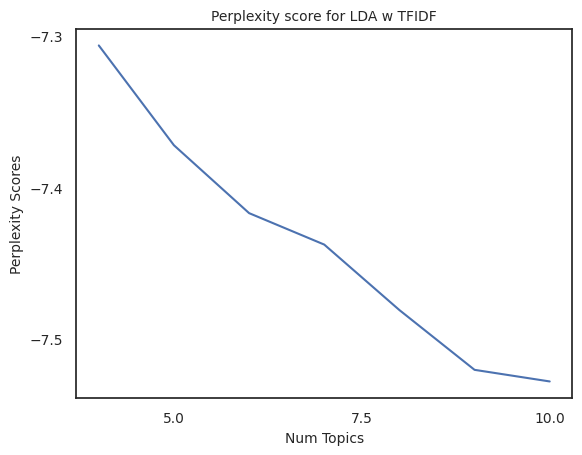

In [91]:
plt.plot(X, nps_perplexity_values, color='b', label='tfidf')
plt.xlabel("Num Topics", fontsize=10)
plt.ylabel("Perplexity Scores", fontsize=10)
plt.title("Perplexity score for LDA w TFIDF", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Coherence score

Another evaluation metric to measure the semantic similarity between the top words

Here, we iterated through the number of topics to determine the coherence scores

In [63]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model= models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model = models.LdaMulticore(corpus, num_topics = num_topics, id2word=dictionary, chunksize = 100,
                                            
                                            iterations= 25, passes=2, workers=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
from gensim.models import CoherenceModel


In [65]:
nps_model_list, nps_coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_words_trigrams, start=4, limit=11, step=1)


In [ ]:
nps_model_list, nps_coherence_values

([<gensim.models.ldamodel.LdaModel at 0x7f16bbb24940>,
 [0.3525228471598163,
  0.2933565391840964,
  0.351148016500252,
  0.32476106242861513,
  0.31297863773867274,
  0.3196848326488996,
  0.3277095086192855])

Graph showing the coherence score variations

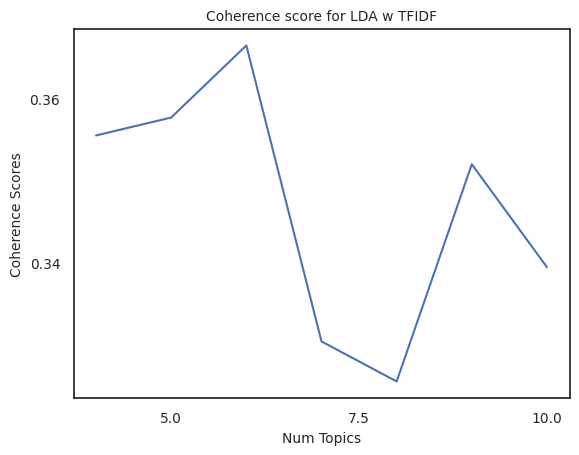

In [96]:
plt.plot(X,nps_coherence_values, color='b', label='tfidf')
plt.xlabel("Num Topics", fontsize=10)
plt.ylabel("Coherence Scores", fontsize=10)
plt.title("Coherence score for LDA w TFIDF", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Computing coherence scores for each segments in the NPS data 

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model= models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        # model = models.LdaMulticore(corpus, num_topics = num_topics, id2word=dictionary, chunksize = 100,
                                            
        #                                     iterations= 25, passes=2, workers=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [68]:
prom_nps_model_list, prom_nps_coherence_values = compute_coherence_values(dictionary=prom_dictionary, corpus=prom_corpus, texts=prom_words_trigrams, start=2, limit=11, step=1)
pass_nps_model_list, pass_nps_coherence_values = compute_coherence_values(dictionary=pass_dictionary, corpus=pass_corpus, texts=pass_words_trigrams, start=2, limit=11, step=1)
det_nps_model_list, det_nps_coherence_values = compute_coherence_values(dictionary=det_dictionary, corpus=det_corpus, texts=det_words_trigrams, start=2, limit=11, step=1)


Coherence scores for each groups plotted below

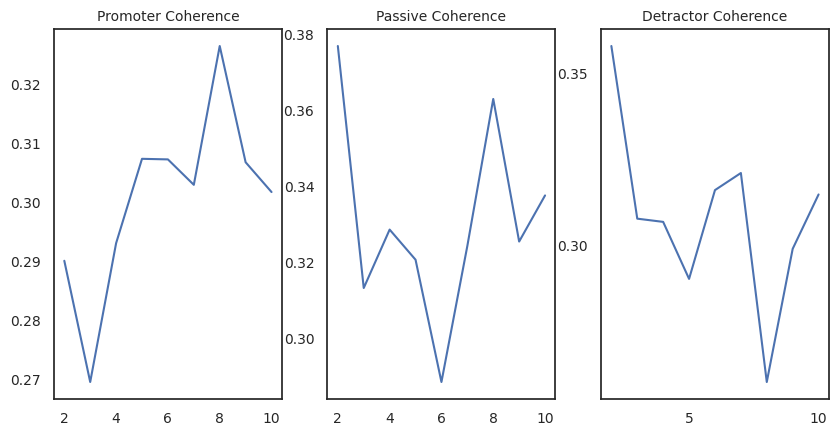

In [103]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3)
figure.set_figwidth(10)

X2 = range(2,11)
ax1.plot(X2, prom_nps_coherence_values)
ax1.set_title("Promoter Coherence", fontsize=10)
ax3.plot(X2, det_nps_coherence_values)
ax3.set_title("Detractor Coherence", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(X2, pass_nps_coherence_values)
ax2.set_title("Passive Coherence", fontsize = 10)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
